In [2]:
import matplotlib.pyplot as plt
import numpy as np
import gym
import pandas as pd
import csv
import openpyxl
import matplotlib.pyplot as plt
import pywt

from gym import spaces
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.linear_model import LinearRegression
from scipy.signal import find_peaks
from scipy.signal import savgol_filter
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from scipy.ndimage import gaussian_filter1d
from scipy.signal import medfilt
from sklearn.preprocessing import MinMaxScaler

In [3]:
# GENERATE TRAIN AND TEST DATA
def split_columns(file_path, first_percentage):
    wb = openpyxl.load_workbook(file_path, data_only=True)
    sheet = wb.active

    num_columns = sheet.max_column
    first_columns_count = int(num_columns * first_percentage)
    last_columns_count = num_columns - first_columns_count

    first_columns = []
    last_columns = []

    for row in sheet.iter_rows(values_only=True):
        first_columns.append(row[:first_columns_count])
        last_columns.append(row[first_columns_count:])

    return first_columns, last_columns


excel_file_path = "dataset_normal_person01.xlsx"
first_percentage = 0.8

first_columns, last_columns = split_columns(excel_file_path, first_percentage)

train_data = first_columns
test_data = last_columns

In [4]:
# Environment and Learning Agent
# class ECGForecastEnv:
#     def __init__(self, data, window_size):
#         self.data = data
#         self.window_size = window_size
#         self.current_step = 0
#         self.current_state = None

#     def reset(self):
#         self.current_step = 0
#         self.current_state = self.data[self.current_step: self.current_step + self.window_size]
#         return self.current_state

#     def calculate_reward(self, forecasted_value, true_value):
#         error = np.abs(forecasted_value - true_value)
#         return 1.0 / (error + 1e-6)  # Add a small constant to prevent division by zero

#     def step(self, action):
#         self.current_step += 1
#         forecasted_value = np.mean(self.current_state) + action  # Adjust forecast based on the action
#         true_value = self.data[self.current_step + self.window_size]
#         reward = self.calculate_reward(forecasted_value, true_value)
#         done = self.current_step >= len(self.data) - self.window_size - 1

#         # Update the current state with the newly observed value
#         self.current_state = np.roll(self.current_state, -1)
#         self.current_state[-1] = forecasted_value

#         return self.current_state, reward, done, {}

class ECGForecastEnv:
    def __init__(self, data, window_size, spike_penalty_weight, spike_threshold, smoothness_weight):
        self.data = data
        self.window_size = window_size
        self.current_step = 0
        self.current_state = None
        self.spike_penalty_weight = spike_penalty_weight
        self.spike_threshold = spike_threshold
        self.smoothness_weight = smoothness_weight

    def reset(self):
        self.current_step = 0
        self.current_state = self.data[self.current_step: self.current_step + self.window_size]
        return self.current_state

    def calculate_reward(self, forecasted_value, true_value):
        error = np.abs(forecasted_value - true_value)
        spike_penalty = self.spike_penalty_weight * (error > self.spike_threshold)
        smoothness_reward = -self.smoothness_weight * np.abs(forecasted_value - np.mean(self.current_state))
        total_reward = 1.0 / (error + 1e-6) + spike_penalty + smoothness_reward
        return total_reward

    def step(self, action):
        self.current_step += 1
        forecasted_value = np.mean(self.current_state) + action  # Adjust forecast based on the action
        true_value = self.data[self.current_step + self.window_size]
        reward = self.calculate_reward(forecasted_value, true_value)
        done = self.current_step >= len(self.data) - self.window_size - 1

        # Update the current state with the newly observed value
        self.current_state = np.roll(self.current_state, -1)
        self.current_state[-1] = forecasted_value

        return self.current_state, reward, done, {}






class QLearningAgent:
    def __init__(self, learning_rate=0.1, discount_factor=0.95, epsilon=0.3):
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.epsilon = epsilon
        self.action_space = np.linspace(-0.1, 0.1, 21)  # Number of discrete actions for amplitude adjustments
        self.state_weights = np.random.rand(num_time_steps)  # Initialize state-action weights
        self.state_window = np.zeros(num_time_steps)  # Initialize the sliding window for state representation

    def choose_action(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.choice(len(self.action_space))  # Choose a random action
        else:
            q_values = np.dot(self.state_weights, state)  # Use state-action weights
            action_idx = np.argmax(q_values)  # Choose the action with the highest Q-value
            return action_idx

    def update_q_table(self, state, action, reward, next_state):
        # Calculate the target Q-value using the Bellman equation
        target_q_value = reward + self.discount_factor * np.max(np.dot(self.state_weights, next_state))

        td_error = target_q_value - np.dot(self.state_weights, state)  # Use state-action weights
        self.state_weights += self.learning_rate * td_error * state

In [5]:
### Fix train_data: Denoise, R-Peaks and Alignment, mean, standard dev, RR

#### DENOISE THE ECG WITH WAVELET DECOMPOSITION
# Generate a synthetic ECG signal (replace this with your actual data)
fs = 1/0.002  # Sampling frequency (Hz)
t = np.arange(0, 8000) / fs  # Time vector based on signal length
ecg_signal = np.array(train_data).reshape(-1)  # Replace with your actual ECG data
# Choose wavelet and decomposition level
wavelet_name = 'db4'  # Daubechies 4
level = 5
# Perform wavelet decomposition
coeffs = pywt.wavedec(ecg_signal, wavelet_name, level=level)
# Apply thresholding to denoise the wavelet coefficients
threshold = 0.2  # Adjust this threshold value as needed
denoised_coeffs = [pywt.threshold(c, value=threshold, mode='soft') for c in coeffs]
# Reconstruct the denoised ECG signal using inverse wavelet transform
denoised_signal = pywt.waverec(denoised_coeffs, wavelet_name)

#### DETERMINE R-PEAKS AND ALSO ALIGN R-PEAK TO TIME ZERO
# Generate a synthetic ECG signal (replace this with your actual data)
fs = 1/0.002  # Sampling frequency (Hz)
t = np.arange(0, 8000) / fs  # Time vector based on signal length
ecg_signal = denoised_signal
#### Find R-Peak and Align R-Peak to zeros
# Find the relatively highest points (R-peaks) in the ECG signal
r_peak_indices, _ = find_peaks(ecg_signal, height=0, distance=300)
# Sort the R-peak indices in ascending order
r_peak_indices_sorted = sorted(r_peak_indices)
# Remove the first R-peak index
r_peak_indices_sorted = r_peak_indices_sorted[1:]
# Find the index corresponding to the second R-peak occurrence
second_r_peak_index = r_peak_indices_sorted[0]  # Now this is the first element
# Set the second R-peak occurrence at time 0
time_shift = -t[second_r_peak_index]
t_shifted = t + time_shift
# Find the index corresponding to time 0
zero_index = np.argmax(t_shifted >= 0)
ecg_signal = ecg_signal[zero_index:]

#### Calculate the mean and standard deviation and RR distance
mean_value = np.mean(ecg_signal)
std_deviation = np.std(ecg_signal)
print("Mean:", mean_value)
print("Standard Deviation:", std_deviation)
# Find R-peaks using scipy's find_peaks
peaks, _ = find_peaks(ecg_signal, height=0, distance=300)
# Calculate the number of samples between consecutive R-peaks
samples_between_rpeaks = np.diff(peaks)
average_samples_between_rpeaks = np.mean(samples_between_rpeaks)
print("Averge between R-peaks: ", average_samples_between_rpeaks)

Mean: 0.007312202900405614
Standard Deviation: 0.08537717871357536
Averge between R-peaks:  410.05882352941177


In [6]:
# TRAIN the Model
num_time_steps = 5 #int(average_samples_between_rpeaks) #len(ecg_signal)
X_fake_ecg = ecg_signal

# Create the environment
#env = ECGForecastEnv(data=X_fake_ecg, window_size=num_time_steps)
#env = ECGForecastEnv(data=X_fake_ecg, window_size=num_time_steps, spike_penalty_weight=10)
env = ECGForecastEnv(data=X_fake_ecg, window_size=5, spike_penalty_weight=10, spike_threshold=0.5, smoothness_weight=0.1)

# Create the Q-learning agent
agent = QLearningAgent()

# Train the agent with Q-learning
num_episodes = 250
total_rewards = np.zeros(num_episodes)  # Track total rewards for each episode

for episode in range(num_episodes):
    state = env.reset()
    done = False
    total_reward = 0
    
    while not done:
        action = agent.choose_action(state)
        
        # Clip the action to ensure it falls within the valid range
        action = max(min(action, len(agent.action_space) - 1), 0)
        
        next_state, reward, done, _ = env.step(action)
        agent.update_q_table(state, action, reward, next_state)
        total_reward += reward
        state = next_state
    
    total_rewards[episode] = total_reward
    
    print(f"Episode {episode + 1} - Total Reward: {total_reward}")

print("Training completed.")

/tmp/ipykernel_21613/3543315631.py:92: RuntimeWarning: invalid value encountered in scalar subtract
  td_error = target_q_value - np.dot(self.state_weights, state)  # Use state-action weights


Episode 1 - Total Reward: 70550.70298934568
Episode 2 - Total Reward: 70458.42030261827
Episode 3 - Total Reward: 70430.00699527882
Episode 4 - Total Reward: 70459.0936227174
Episode 5 - Total Reward: 70484.30626470831
Episode 6 - Total Reward: 70458.17985061083
Episode 7 - Total Reward: 70499.47011839946
Episode 8 - Total Reward: 70587.3937263762
Episode 9 - Total Reward: 70389.15649732068
Episode 10 - Total Reward: 70528.21109487394
Episode 11 - Total Reward: 70481.80760832323
Episode 12 - Total Reward: 70390.03169698741
Episode 13 - Total Reward: 70488.09439955227
Episode 14 - Total Reward: 70444.93559433696
Episode 15 - Total Reward: 70442.49398089948
Episode 16 - Total Reward: 70526.20213955315
Episode 17 - Total Reward: 70445.55748212159
Episode 18 - Total Reward: 70492.11923766542
Episode 19 - Total Reward: 70528.44081289267
Episode 20 - Total Reward: 70482.68879306721
Episode 21 - Total Reward: 70468.15972083023
Episode 22 - Total Reward: 70469.37290732472
Episode 23 - Total Re

In [ ]:
######### TESTING THE DATA #############
######### TESTING THE DATA #############
######### TESTING THE DATA #############
######### TESTING THE DATA #############
######### TESTING THE DATA #############

In [7]:
### Fix train_data: Denoise, R-Peaks and Alignment, mean, standard dev, RR

#### DENOISE THE ECG WITH WAVELET DECOMPOSITION
# Generate a synthetic ECG signal (replace this with your actual data)
fs = 1/0.002  # Sampling frequency (Hz)
t = np.arange(0, 2000) / fs  # Time vector based on signal length
ecg_signal = np.array(test_data).reshape(-1)  # Replace with your actual ECG data
# Choose wavelet and decomposition level
wavelet_name = 'db4'  # Daubechies 4
level = 5
# Perform wavelet decomposition
coeffs = pywt.wavedec(ecg_signal, wavelet_name, level=level)
# Apply thresholding to denoise the wavelet coefficients
threshold = 0.2  # Adjust this threshold value as needed
denoised_coeffs = [pywt.threshold(c, value=threshold, mode='soft') for c in coeffs]
# Reconstruct the denoised ECG signal using inverse wavelet transform
denoised_signal = pywt.waverec(denoised_coeffs, wavelet_name)

#### DETERMINE R-PEAKS AND ALSO ALIGN R-PEAK TO TIME ZERO
# Generate a synthetic ECG signal (replace this with your actual data)
fs = 1/0.002  # Sampling frequency (Hz)
t = np.arange(0, 2000) / fs  # Time vector based on signal length
ecg_signal = denoised_signal
#### Find R-Peak and Align R-Peak to zeros
# Find the relatively highest points (R-peaks) in the ECG signal
r_peak_indices, _ = find_peaks(ecg_signal, height=0, distance=300)
# Sort the R-peak indices in ascending order
r_peak_indices_sorted = sorted(r_peak_indices)
# Remove the first R-peak index
r_peak_indices_sorted = r_peak_indices_sorted[1:]
# Find the index corresponding to the second R-peak occurrence
second_r_peak_index = r_peak_indices_sorted[0]  # Now this is the first element
# Set the second R-peak occurrence at time 0
time_shift = -t[second_r_peak_index]
t_shifted = t + time_shift
# Find the index corresponding to time 0
zero_index = np.argmax(t_shifted >= 0)
ecg_signal = ecg_signal[zero_index:]

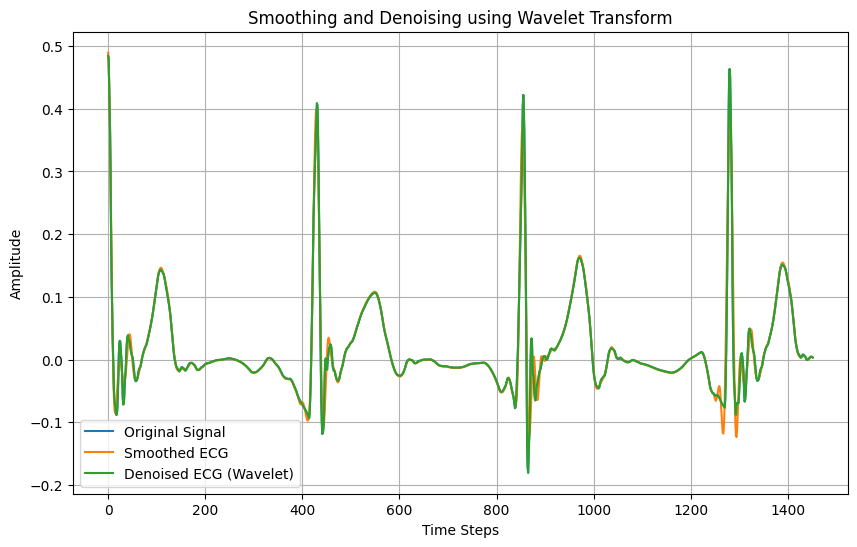

MAPE: 69.65955415240434


In [26]:
# Perform inference with the trained agent (forecasting ECG data)
X_fake_ecg = ecg_signal
num_time_steps = 5 #int(average_samples_between_rpeaks)
state = env.reset()
predicted_ecg = []

while len(predicted_ecg) < len(X_fake_ecg) - num_time_steps:  # Adjust loop to match data lengths
    action = agent.choose_action(state)

    # Append the forecasted value to the list of predicted ECG values
    forecasted_value = np.mean(state) + agent.action_space[action]  # Use weighted average for forecasting
    predicted_ecg.append(float(forecasted_value))  # Convert the scalar value to float

    # Update the current state with the newly observed value
    state = np.roll(state, -1)
    state[-1] = X_fake_ecg[len(predicted_ecg) + num_time_steps - 1]  # Use the true value for forecasting


min_length = min(len(X_fake_ecg), len(predicted_ecg))
time = np.arange(min_length)
X_fake_ecg = X_fake_ecg[:min_length]
predicted_ecg = predicted_ecg[:min_length]

# Choose wavelet and decomposition level
wavelet_name = 'db4'  # Daubechies 4
level = 5
coeffs = pywt.wavedec(X_fake_ecg, wavelet_name, level=level)
threshold = 0.0000  # Adjust this threshold value as needed
denoised_coeffs = [pywt.threshold(c, value=threshold, mode='hard') for c in coeffs]
denoised_ecg = pywt.waverec(denoised_coeffs, wavelet_name)

# Smooth the signal
window_size = 67  # Must be an odd number
order = 10  # Polynomial order
smoothed_ecg = savgol_filter(denoised_ecg, window_size, order)


difference = np.mean(X_fake_ecg) - np.mean(smoothed_ecg)
smoothed_ecg = smoothed_ecg + difference

difference = np.mean(X_fake_ecg) - np.mean(denoised_ecg)
denoised_ecg = denoised_ecg + difference


# Plot the original, smoothed, and denoised signals
plt.figure(figsize=(10, 6))
plt.plot(time, X_fake_ecg, label='Original Signal')
plt.plot(time, denoised_ecg, label='Denoised ECG (Wavelet)')
plt.plot(time, smoothed_ecg, label='Smoothed ECG')
plt.xlabel('Time Steps')
plt.ylabel('Amplitude')
plt.title('Smoothing and Denoising using Wavelet Transform')
plt.legend()
plt.grid(True)
plt.show()

def calculate_mape(actual, predicted):
    actual = np.array(actual)
    predicted = np.array(predicted)
    mape = np.sum(np.abs((actual - predicted) / actual)) / len(actual) * 100
    return mape

mape_result = calculate_mape(X_fake_ecg, smoothed_ecg)
print("MAPE:", mape_result)

In [ ]:
####### TEST WITH ANOMALY #######
####### TEST WITH ANOMALY #######
####### TEST WITH ANOMALY #######
####### TEST WITH ANOMALY #######
####### TEST WITH ANOMALY #######

In [27]:
### Fix train_data: Denoise, R-Peaks and Alignment, mean, standard dev, RR

#### DENOISE THE ECG WITH WAVELET DECOMPOSITION
# Generate a synthetic ECG signal (replace this with your actual data)
fs = 1/0.002  # Sampling frequency (Hz)
t = np.arange(0, 2000) / fs  # Time vector based on signal length
ecg_signal = np.array(test_data).reshape(-1)  # Replace with your actual ECG data
# Choose wavelet and decomposition level
wavelet_name = 'db4'  # Daubechies 4
level = 5
# Perform wavelet decomposition
coeffs = pywt.wavedec(ecg_signal, wavelet_name, level=level)
# Apply thresholding to denoise the wavelet coefficients
threshold = 0.2  # Adjust this threshold value as needed
denoised_coeffs = [pywt.threshold(c, value=threshold, mode='soft') for c in coeffs]
# Reconstruct the denoised ECG signal using inverse wavelet transform
denoised_signal = pywt.waverec(denoised_coeffs, wavelet_name)

#### DETERMINE R-PEAKS AND ALSO ALIGN R-PEAK TO TIME ZERO
# Generate a synthetic ECG signal (replace this with your actual data)
fs = 1/0.002  # Sampling frequency (Hz)
t = np.arange(0, 2000) / fs  # Time vector based on signal length
ecg_signal = denoised_signal
#### Find R-Peak and Align R-Peak to zeros
# Find the relatively highest points (R-peaks) in the ECG signal
r_peak_indices, _ = find_peaks(ecg_signal, height=0, distance=300)
# Sort the R-peak indices in ascending order
r_peak_indices_sorted = sorted(r_peak_indices)
# Remove the first R-peak index
r_peak_indices_sorted = r_peak_indices_sorted[1:]
# Find the index corresponding to the second R-peak occurrence
second_r_peak_index = r_peak_indices_sorted[0]  # Now this is the first element
# Set the second R-peak occurrence at time 0
time_shift = -t[second_r_peak_index]
t_shifted = t + time_shift
# Find the index corresponding to time 0
zero_index = np.argmax(t_shifted >= 0)
ecg_signal = ecg_signal[zero_index:]

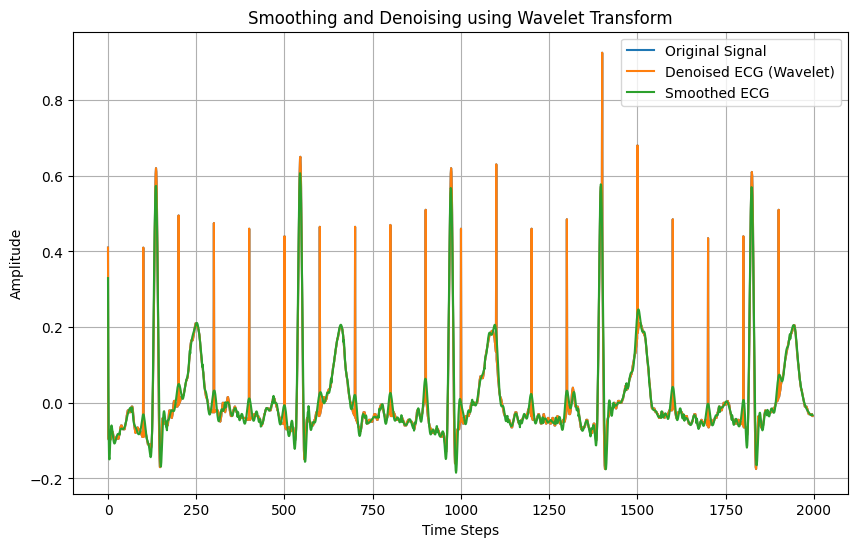

MAPE: 2469708.716996895
Number of measurement above threshold:  19
Accuracy (with original being 20 total):  95.0


In [ ]:
### Add anomaly
# Generate a synthetic ECG signal (replace this with your actual data)
fs = 1/0.002  # Sampling frequency (Hz)
t = np.arange(0, 2000) / fs  # Time vector based on signal length
ecg_signal = np.array(test_data).reshape(-1)  # Replace with your actual ECG data
amplitude = mean_value + 3 * std_deviation

# Create a sinusoidal time series
original_time_series = ecg_signal

# Define parameters for the periodic bump
bump_period = 100*0.002  # Period of the bump (in seconds)
bump_duration = 0.002  # Duration of each bump (in seconds)
bump_amplitude = 0.5  # Amplitude of the bump

# Convert bump period from seconds to samples
bump_period_samples = int(bump_period * fs)

# Create a bump pattern
bump_pattern = np.zeros_like(t)
bump_indices = np.arange(0, len(t), bump_period_samples)
for idx in bump_indices:
    bump_pattern[idx:idx+int(bump_duration * fs)] = bump_amplitude

# Add the bump pattern to the original time series
time_series_with_bumps = original_time_series + bump_pattern

# Perform inference with the trained agent (forecasting ECG data)
X_fake_ecg = time_series_with_bumps
num_time_steps = 3 #int(average_samples_between_rpeaks)
state = env.reset()
predicted_ecg = []

while len(predicted_ecg) < len(X_fake_ecg) - num_time_steps:  # Adjust loop to match data lengths
    action = agent.choose_action(state)

    # Append the forecasted value to the list of predicted ECG values
    forecasted_value = np.mean(state) + agent.action_space[action]  # Use weighted average for forecasting
    predicted_ecg.append(float(forecasted_value))  # Convert the scalar value to float

    # Update the current state with the newly observed value
    state = np.roll(state, -1)
    state[-1] = X_fake_ecg[len(predicted_ecg) + num_time_steps - 1]  # Use the true value for forecasting

min_length = min(len(X_fake_ecg), len(predicted_ecg))
time = np.arange(min_length)
X_fake_ecg = X_fake_ecg[:min_length]
predicted_ecg = predicted_ecg[:min_length]

# Choose wavelet and decomposition level
wavelet_name = 'db4'  # Daubechies 4
level = 5
coeffs = pywt.wavedec(X_fake_ecg, wavelet_name, level=level)
threshold = 0.0000  # Adjust this threshold value as needed
denoised_coeffs = [pywt.threshold(c, value=threshold, mode='hard') for c in coeffs]
denoised_ecg = pywt.waverec(denoised_coeffs, wavelet_name)

# Smooth the signal
window_size = 67  # Must be an odd number
order = 10  # Polynomial order
smoothed_ecg = savgol_filter(denoised_ecg, window_size, order)


difference = np.mean(X_fake_ecg) - np.mean(smoothed_ecg)
smoothed_ecg = smoothed_ecg + difference

difference = np.mean(X_fake_ecg) - np.mean(denoised_ecg)
denoised_ecg = denoised_ecg + difference

min_length = min(len(time), len(denoised_ecg), len(smoothed_ecg))
time = time[:min_length]
denoised_ecg = denoised_ecg[:min_length]
smoothed_ecg = smoothed_ecg[:min_length]

# Plot the original, smoothed, and denoised signals
plt.figure(figsize=(10, 6))
plt.plot(time, X_fake_ecg, label='Original Signal')
plt.plot(time, denoised_ecg, label='Denoised ECG (Wavelet)')
plt.plot(time, smoothed_ecg, label='Smoothed ECG')
plt.xlabel('Time Steps')
plt.ylabel('Amplitude')
plt.title('Smoothing and Denoising using Wavelet Transform')
plt.legend()
plt.grid(True)
plt.show()

# Count the number of values above the threshold
distance = np.abs(X_fake_ecg - smoothed_ecg)
threshold = amplitude
count_above_threshold = np.sum(distance >= threshold)
print("Number of measurement above threshold: ", count_above_threshold)
print("Accuracy (with original being 20 total): ", count_above_threshold / 20.0 * 100.0)